# How and Why Does Dropout Work?

## What is Dropout? 

The idea behind dropout is quite simple - during the training phase, a randomly selected subset of neurons is "dropped out" of the computation. This is achieved by setting their activations to 0. A fixed proportion $p$, usually between 10-50%, are "dropped out" during each training step. This value is often different for each layer.

During the testing phase, dropout is not applied, but instead, the outputs of each layer are scaled down by a factor of $1-p$.

Empirically, this results in improved generalization performance (i.e. on the validation or test set).

In this experiment, we will compare two deep neural networks, one without dropout and one with. Then, we will try to understand why dropout results in better performance.

## Let's Start by Loading the CIFAR-10 Dataset

The CIFAR-10 dataset is a popular benchmark for machine learning and computer vision tasks, consisting of 60,000 32x32 color images across 10 distinct classes. Each image is labeled as one of the following categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, or truck. The dataset is divided into 50,000 training images and 10,000 test images, with an even distribution of 6,000 images per class.

Despite its simplicity, the dataset contains a variety of object poses, lighting conditions, and backgrounds, making it non-trivial to achieve high accuracy.


Convolutional Neural Networks and other image-specific architectures are typically trained on this dataset. However, for this experiment, we will use a feedforward network in order to demonstrate the benefits of using dropout.

In [1]:
import tensorflow_datasets as tfds
import jax
import jax.numpy as jnp

train_tf, test_tf = tfds.load('cifar10', split=['train', 'test'], batch_size=-1, as_supervised=True)

raw_train_images, train_labels = train_tf[0], train_tf[1]
raw_train_images = jnp.float32(raw_train_images)
raw_train_images = raw_train_images.reshape((raw_train_images.shape[0], -1))
train_labels = jnp.float32(train_labels)

raw_test_images, test_labels = test_tf[0], test_tf[1]
raw_test_images = jnp.float32(raw_test_images)
raw_test_images = raw_test_images.reshape((raw_test_images.shape[0], -1))
test_labels = jnp.float32(test_labels)

print(f"Training Set Size {raw_train_images.shape[0]}")
print(f"Test Set Size {raw_test_images.shape[0]}")

Training Set Size 50000
Test Set Size 10000


### What Does Our Dataset Look Like? 

Let's look at a few training examples. 

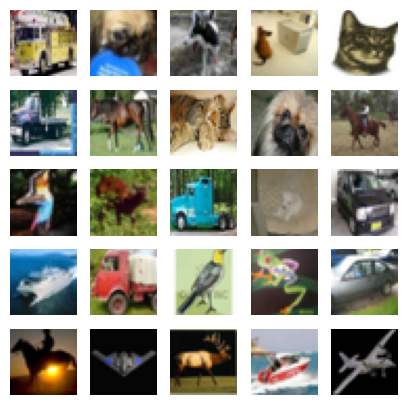

In [2]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import math
plt.style.use('seaborn-v0_8-darkgrid')

RANDOM_KEY = 42

num_examples = 25
row_size = int(math.sqrt(num_examples))
fig, axs = plt.subplots(row_size, row_size, figsize=(row_size,row_size))

rng = jax.random.PRNGKey(RANDOM_KEY)
idxs = jax.random.randint(rng, (num_examples,), 0, raw_train_images.shape[0])
exs = raw_train_images[idxs,:].reshape((num_examples,32,32,3))/255.0

for ex in range(num_examples):
    i = ex // row_size
    j = ex % row_size
    axs[i,j].imshow(exs[ex])
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].set_xmargin(0)
    axs[i,j].set_ymargin(0)

plt.show()

Let's now preprocess the dataset and look at the input feature distrubition.

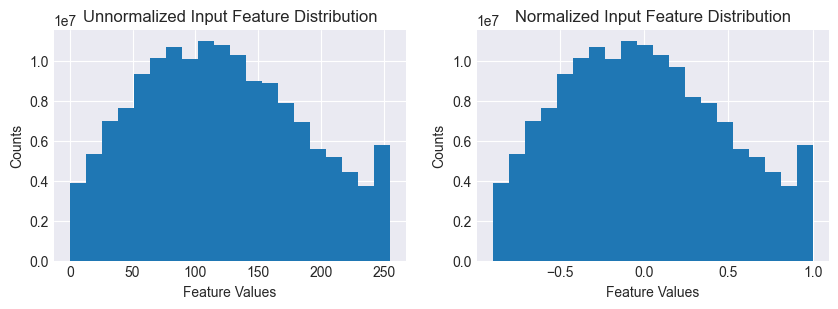

In [3]:
# First, let's plot the histogram for the unnormalized dataset
fig, axs = plt.subplots(1,2, figsize=(10,3))
axs[0].hist(raw_train_images.flatten(), bins=20)
axs[0].set_title("Unnormalized Input Feature Distribution")
axs[0].set_xlabel("Feature Values")
axs[0].set_ylabel("Counts")

# Let's normalize the  dataset
train_mean = raw_train_images.mean()
train_std = raw_train_images.std()
train_images = (raw_train_images - train_mean)/train_std
train_max = train_images.max()
train_images = train_images/train_max

test_mean = raw_test_images.mean()
test_std = raw_test_images.std()
test_images = (raw_test_images - test_mean)/test_std
test_max = test_images.max()
test_images = test_images/test_max

# Now let's plot the the histogram for the normalized dataset
axs[1].hist(train_images.flatten(), bins=20)
axs[1].set_title("Normalized Input Feature Distribution")
axs[1].set_xlabel("Feature Values")
axs[1].set_ylabel("Counts")

plt.show()

## Let's Define the Models

Our baseline model is a fully-connected network with ReLU activations. The output layer has 10 classes to generate logits for our class probabilities. 
The candidate is just the baseline with an additional dropout layer after each ReLU activation (except the final layer).

The dropout layer is placed after the ReLU activation because we want to only remove those neurons that participate in classifying an example. Removing neurons with zero or negative values will not serve this purpose. In fact, it may lead to 'dead neurons' which never activate.

In [4]:
from typing import Dict, Any

from functools import reduce
import operator

from time import sleep

from flax import linen as nn
from flax.training import train_state
import optax

rng = jax.random.PRNGKey(RANDOM_KEY)


class MLP(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool = True):
        outputs = {}
        x = nn.Dense(256)(x)             
        outputs['Dense_0'] = x
        x = nn.BatchNorm(use_running_average=not train)(x)  
        outputs['BatchNorm_0'] = x
        x = nn.relu(x)
        outputs['Relu_0'] = x

        x = nn.Dense(128)(x)             
        outputs['Dense_1'] = x
        x = nn.BatchNorm(use_running_average=not train)(x)  
        outputs['BatchNorm_1'] = x
        x = nn.relu(x)
        outputs['Relu_1'] = x

        x = nn.Dense(64)(x)              
        outputs['Dense_2'] = x
        x = nn.BatchNorm(use_running_average=not train)(x)  
        outputs['BatchNorm_2'] = x
        x = nn.relu(x)
        outputs['Relu_2'] = x

        x = nn.Dense(32)(x)              
        outputs['Dense_3'] = x
        x = nn.BatchNorm(use_running_average=not train)(x)  
        outputs['BatchNorm_3'] = x
        x = nn.relu(x)
        outputs['Relu_3'] = x

        x = nn.Dense(10)(x)              
        outputs['Dense_4'] = x
        return x, outputs

# Initialize the candidate model
baseline_model = MLP()
dummy_input = jnp.ones((32, 32*32*3))
baseline_variables = baseline_model.init(rng, dummy_input, train=True)
baseline_params = baseline_variables['params']
baseline_batch_stats = baseline_variables['batch_stats']
dropout=0.4

class MLPDropout(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool = True, rng = None):
        outputs = {}
        x = nn.Dense(256)(x)             
        outputs['Dense_0'] = x
        x = nn.BatchNorm(use_running_average=not train)(x)  
        outputs['BatchNorm_0'] = x
        x = nn.relu(x)
        outputs['Relu_0'] = x
        x = nn.Dropout(rate=0.4, deterministic=not train)(x, rng=rng)
        outputs['Dropout_0'] = x

        x = nn.Dense(128)(x)             
        outputs['Dense_1'] = x
        x = nn.BatchNorm(use_running_average=not train)(x)  
        outputs['BatchNorm_1'] = x
        x = nn.relu(x)
        outputs['Relu_1'] = x
        x = nn.Dropout(rate=0.3, deterministic=not train)(x, rng=rng)
        outputs['Dropout_1'] = x

        x = nn.Dense(64)(x)              
        outputs['Dense_2'] = x
        x = nn.BatchNorm(use_running_average=not train)(x)  
        outputs['BatchNorm_2'] = x
        x = nn.relu(x)
        outputs['Relu_2'] = x
        x = nn.Dropout(rate=0.2, deterministic=not train)(x, rng=rng)
        outputs['Dropout_2'] = x

        x = nn.Dense(32)(x)              
        outputs['Dense_3'] = x
        x = nn.BatchNorm(use_running_average=not train)(x)  
        outputs['BatchNorm_3'] = x
        x = nn.relu(x)
        outputs['Relu_3'] = x
        x = nn.Dropout(rate=0.2, deterministic=not train)(x, rng=rng)
        outputs['Dropout_3'] = x

        x = nn.Dense(10)(x)              
        outputs['Dense_4'] = x
        return x, outputs

# Initialize the candidate model
candidate_model = MLPDropout()
dummy_input = jnp.ones((32, 32*32*3))
candidate_variables = candidate_model.init(rng, dummy_input, train=True, rng=rng)
candidate_params = candidate_variables['params']
candidate_batch_stats = candidate_variables['batch_stats']



#### Let's count the parameters and plot the initial distributions for the parameter values.

Number of baseline parameters: 831210
Baseline P/S ratio: 16.6242
Number of candidate parameters: 831210
Candidate P/S ratio: 16.6242


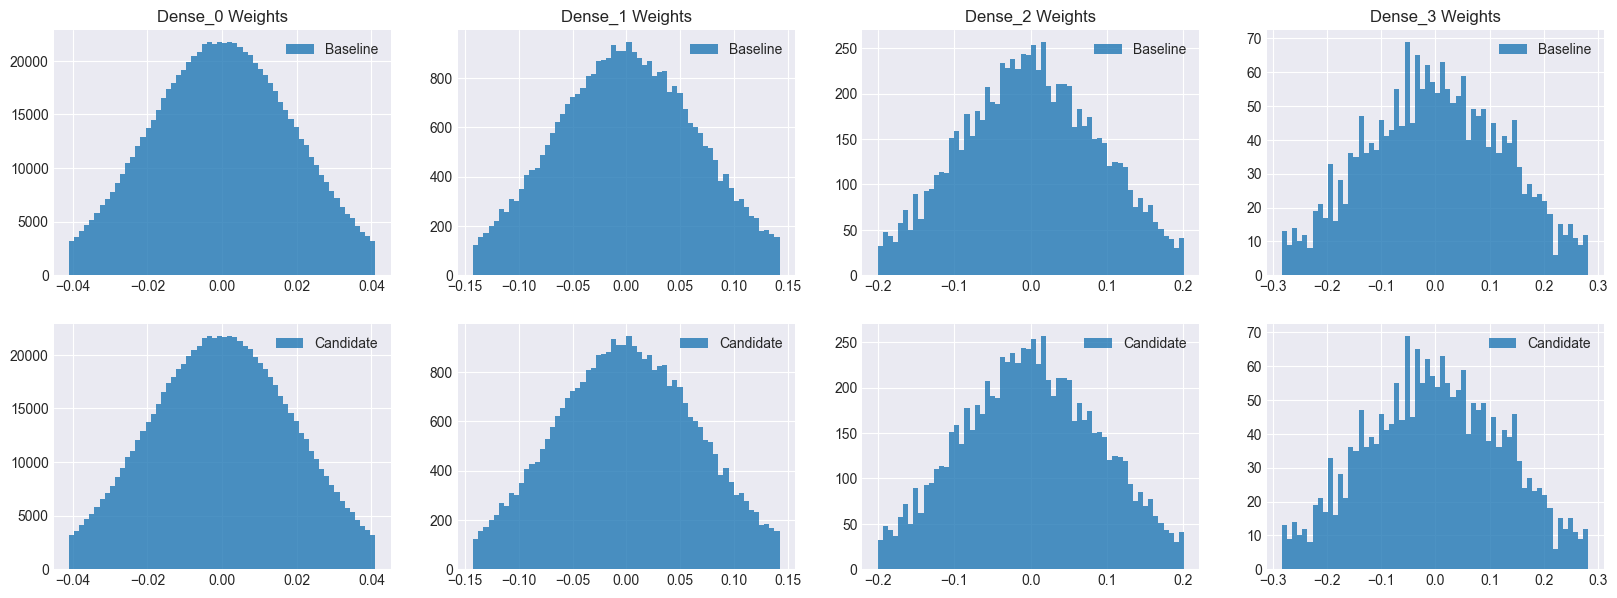

In [5]:

# Count the # of model parameters
def count_params(params):
    num_params = 0
    for layer in params:
        for key in params[layer]:
            shape = params[layer][key].shape
            num_params += reduce(operator.mul, shape)
    return num_params

num_baseline_params = count_params(baseline_params)
num_candidate_params = count_params(candidate_params)

print(f"Number of baseline parameters: {num_baseline_params}")
print(f"Baseline P/S ratio: {num_baseline_params/train_images.shape[0]:0.4f}")
print(f"Number of candidate parameters: {num_candidate_params}")
print(f"Candidate P/S ratio: {num_candidate_params/train_images.shape[0]:0.4f}")

# Lets plot the initial baseline model weight distributions
fig, axs = plt.subplots(2, 4, figsize=[20, 7])

baseline_dense0_w = baseline_params['Dense_0']['kernel'].flatten()
candidate_dense0_w = candidate_params['Dense_0']['kernel'].flatten()

baseline_dense1_w = baseline_params['Dense_1']['kernel'].flatten()
candidate_dense1_w = candidate_params['Dense_1']['kernel'].flatten()

baseline_dense2_w = baseline_params['Dense_2']['kernel'].flatten()
candidate_dense2_w = candidate_params['Dense_2']['kernel'].flatten()

baseline_dense3_w = baseline_params['Dense_3']['kernel'].flatten()
candidate_dense3_w = candidate_params['Dense_3']['kernel'].flatten()

axs[0,0].hist(baseline_dense0_w, bins=60, alpha=0.8)
axs[0,0].set_title("Dense_0 Weights")
axs[0,0].legend(["Baseline"])
axs[0,1].hist(baseline_dense1_w, bins=60, alpha=0.8)
axs[0,1].set_title("Dense_1 Weights")
axs[0,1].legend(["Baseline"])
axs[0,2].hist(baseline_dense2_w, bins=60, alpha=0.8)
axs[0,2].set_title("Dense_2 Weights")
axs[0,2].legend(["Baseline"])
axs[0,3].hist(baseline_dense3_w, bins=60, alpha=0.8)
axs[0,3].set_title("Dense_3 Weights")
axs[0,3].legend(["Baseline"])

axs[1,0].hist(candidate_dense0_w, bins=60, alpha=0.8)
axs[1,0].legend(["Candidate"])
axs[1,1].hist(candidate_dense1_w, bins=60, alpha=0.8)
axs[1,1].legend(["Candidate"])
axs[1,2].hist(candidate_dense2_w, bins=60, alpha=0.8)
axs[1,2].legend(["Candidate"])
axs[1,3].hist(candidate_dense3_w, bins=60, alpha=0.8)
axs[1,3].legend(["Candidate"])



plt.show()

As you can see, both models have the same number of parameters as well as initial distributions. Hence, we can safely assume that any performance improvement seen by the candidate model will be due to dropout.

In [6]:
import os
import tempfile
import numpy as np

try:
    type(tmpdir)
except:
    base_temp_dir = tempfile.gettempdir()
    tmpdir = os.path.join(base_temp_dir, "model_outputs")
    os.makedirs(tmpdir, exist_ok=True)

def save_accuracy_to_disk(model, phase, metrics, tmpdir=tmpdir):
        filename = f'{tmpdir}/{model}_{phase}_accuracy.npy'
        jnp.save(filename, metrics)

def load_accuracy_from_disk(model, phase, tmpdir=tmpdir):
        filename = f'{tmpdir}/{model}_{phase}_accuracy.npy'
        if os.path.exists(filename):
            return jnp.load(filename)

def save_outputs_to_disk(model, phase, epoch, outputs, tmpdir=tmpdir):
    for key in outputs:
        filename = f'{tmpdir}/{model}_{phase}_outputs_epoch_{epoch}_{key}.npy'
        jnp.save(filename, outputs[key])


def load_outputs_from_disk(model, phase, epoch, layer, tmpdir=tmpdir):
    filename = f'{tmpdir}/{model}_{phase}_outputs_epoch_{epoch}_{layer}.npy'
    if os.path.exists(filename):
        return jnp.load(filename)
    else:
        print(f"No data found for file {filename}")
        return None



In [7]:
try:
    type(tmpdir)
except:
    tmpdir = "/var/folders/x4/85_9sn3d1ng9q48ff6t3fw340000gn/T/model_outputs"

## Let's Train the Baseline Model

In [8]:
import optax
from flax.training import train_state

rng = jax.random.PRNGKey(RANDOM_KEY)
LR = 0.001
num_epochs = 200
batch_size = 32

In [9]:
# Create a train state
tx = optax.adam(learning_rate=LR)
baseline_ts = train_state.TrainState.create(apply_fn=baseline_model.apply, params=baseline_params, tx=tx)

def compute_loss(params, batch_stats, apply_fn, images, labels, train):
    variables = {'params': params, 'batch_stats': batch_stats}
    outputs, updated_variables = apply_fn(variables, images, train=train, mutable=['batch_stats'])
    logits, _ = outputs
    one_hot_labels = jax.nn.one_hot(labels, 10)
    loss = optax.softmax_cross_entropy(logits, one_hot_labels).mean()
    return loss, updated_variables['batch_stats']

@jax.jit
def train_step(state, batch_stats, images, labels):
    def loss_fn(params):
        return compute_loss(params, batch_stats, state.apply_fn, images, labels, train=True)
    grads, updated_batch_stats = jax.grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    return grads, state, updated_batch_stats

@jax.jit
def eval_step(state, batch_stats, images, labels):
    variables = {'params': state.params, 'batch_stats': batch_stats}
    logits, outputs = state.apply_fn(variables, images, train=False)
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == labels)
    return accuracy, outputs


def train_and_evaluate(rng, model, ts, batch_stats, train_images, train_labels, test_images, test_labels):

    num_train = train_images.shape[0]

    train_accuracy, train_outputs = eval_step(ts, batch_stats, train_images, train_labels)
    save_outputs_to_disk("Baseline", "train", "0", train_outputs)
    train_outputs = None
    test_outputs = None
    test_accuracy, test_outputs = eval_step(ts, batch_stats, test_images, test_labels)
    save_outputs_to_disk("Baseline", "test", "0", test_outputs)
    train_accuracy_history = [train_accuracy]
    test_accuracy_history = [test_accuracy]

    print(f'Epoch 0, Train Accuracy: {train_accuracy:0.4f}, Test Accuracy: {test_accuracy:.4f}')

    for epoch in range(num_epochs):

        rng, sub_rng = jax.random.split(rng)
        permutation = jax.random.permutation(sub_rng, num_train)
        train_images = train_images[permutation]
        train_labels = train_labels[permutation]
        
        for i in range(0, num_train, batch_size):
            batch_images = train_images[i:i + batch_size]
            batch_labels = train_labels[i:i + batch_size]
            grads, ts, batch_stats = train_step(ts, batch_stats, batch_images, batch_labels)

        train_accuracy, train_outputs = eval_step(ts, batch_stats, train_images, train_labels)
        save_outputs_to_disk("Baseline", "train", epoch+1, train_outputs)
        test_accuracy, test_outputs = eval_step(ts, batch_stats, test_images, test_labels)
        save_outputs_to_disk("Baseline", "test", epoch+1, test_outputs)


        if epoch % 50 == 0:
            print(f'Epoch {epoch + 1}, Train Accuracy: {train_accuracy:0.4f}, Test Accuracy: {test_accuracy:.4f}')
        train_accuracy_history.append(train_accuracy)
        test_accuracy_history.append(test_accuracy)

        train_outputs = None
        test_outputs = None

    print(f'Epoch {num_epochs}, Train Accuracy: {train_accuracy_history[-1]:0.4f}, Test Accuracy: {test_accuracy_history[-1]:.4f}')

    save_accuracy_to_disk("Baseline", "train", train_accuracy_history)
    save_accuracy_to_disk("Baseline", "test", test_accuracy_history)

train_and_evaluate(rng, baseline_model, baseline_ts, baseline_batch_stats, train_images, train_labels, test_images, test_labels)


Epoch 0, Train Accuracy: 0.1096, Test Accuracy: 0.1108
Epoch 1, Train Accuracy: 0.4660, Test Accuracy: 0.4513
Epoch 51, Train Accuracy: 0.9228, Test Accuracy: 0.5328
Epoch 101, Train Accuracy: 0.9756, Test Accuracy: 0.5329
Epoch 151, Train Accuracy: 0.9816, Test Accuracy: 0.5228
Epoch 200, Train Accuracy: 0.9936, Test Accuracy: 0.5331


## Next, Let's Train the Candidate Model

In [10]:
# Create a train state
tx = optax.adam(learning_rate=LR)
candidate_ts = train_state.TrainState.create(apply_fn=candidate_model.apply, params=candidate_params, tx=tx)

def compute_loss(params, batch_stats, apply_fn, images, labels, train, rng):
    variables = {'params': params, 'batch_stats': batch_stats}
    outputs, updated_variables = apply_fn(variables, images, train=train, rng=rng,  mutable=['batch_stats'])
    logits, _ = outputs
    one_hot_labels = jax.nn.one_hot(labels, 10)
    loss = optax.softmax_cross_entropy(logits, one_hot_labels).mean()
    return loss, updated_variables['batch_stats']

@jax.jit
def train_step(state, batch_stats, images, labels, rng):
    def loss_fn(params):
        return compute_loss(params, batch_stats, state.apply_fn, images, labels, train=True, rng=rng)
    grads, updated_batch_stats = jax.grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    return grads, state, updated_batch_stats

@jax.jit
def eval_step(state, batch_stats, images, labels, rng):
    variables = {'params': state.params, 'batch_stats': batch_stats}
    logits, outputs = state.apply_fn(variables, images, train=False, rng=rng)
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == labels)
    return accuracy, outputs


def train_and_evaluate(rng, model, ts, batch_stats, train_images, train_labels, test_images, test_labels):

    num_train = train_images.shape[0]

    train_accuracy, train_outputs = eval_step(ts, batch_stats, train_images, train_labels, rng)
    save_outputs_to_disk("Candidate", "train", "0", train_outputs)
    test_accuracy, test_outputs = eval_step(ts, batch_stats, test_images, test_labels, rng)
    save_outputs_to_disk("Candidate", "test", "0", test_outputs)

    print(f'Epoch 0, Train Accuracy: {train_accuracy:0.4f}, Test Accuracy: {test_accuracy:.4f}')
    train_accuracy_history = [train_accuracy]
    test_accuracy_history = [test_accuracy]

    for epoch in range(num_epochs):

        rng, sub_rng = jax.random.split(rng)
        permutation = jax.random.permutation(sub_rng, num_train)
        train_images = train_images[permutation]
        train_labels = train_labels[permutation]
        
        for i in range(0, num_train, batch_size):
            batch_images = train_images[i:i + batch_size]
            batch_labels = train_labels[i:i + batch_size]
            grads, ts, batch_stats = train_step(ts, batch_stats, batch_images, batch_labels, sub_rng)

        train_accuracy, train_outputs = eval_step(ts, batch_stats, train_images, train_labels, sub_rng)
        save_outputs_to_disk("Candidate", "train", epoch+1, train_outputs)
        test_accuracy, test_outputs = eval_step(ts, batch_stats, test_images, test_labels, sub_rng)
        save_outputs_to_disk("Candidate", "test", epoch+1, test_outputs)
        if epoch % 50 == 0:
            print(f'Epoch {epoch + 1}, Train Accuracy: {train_accuracy:0.4f}, Test Accuracy: {test_accuracy:.4f}')
        train_accuracy_history.append(train_accuracy)
        test_accuracy_history.append(test_accuracy)

    save_accuracy_to_disk("Candidate", "train", train_accuracy_history)
    save_accuracy_to_disk("Candidate", "test", test_accuracy_history)

    print(f'Epoch {num_epochs}, Train Accuracy: {train_accuracy_history[-1]:0.4f}, Test Accuracy: {test_accuracy_history[-1]:.4f}')

train_and_evaluate(rng, candidate_model, candidate_ts, candidate_batch_stats, train_images, train_labels, test_images, test_labels)


Epoch 0, Train Accuracy: 0.1096, Test Accuracy: 0.1108
Epoch 1, Train Accuracy: 0.4211, Test Accuracy: 0.4225
Epoch 51, Train Accuracy: 0.6981, Test Accuracy: 0.5640
Epoch 101, Train Accuracy: 0.7710, Test Accuracy: 0.5615
Epoch 151, Train Accuracy: 0.8101, Test Accuracy: 0.5637
Epoch 200, Train Accuracy: 0.8367, Test Accuracy: 0.5632


Let's look at the accuracy metrics over time.

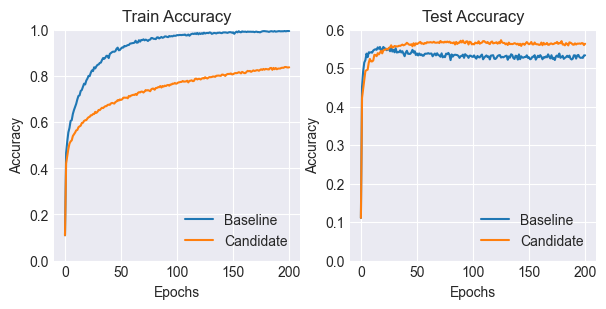

In [11]:
fig, axes = plt.subplots(1,2, figsize=[7,3])

baseline_train_accuracy_history = load_accuracy_from_disk("Baseline", "train")
baseline_test_accuracy_history = load_accuracy_from_disk("Baseline", "test")
candidate_train_accuracy_history = load_accuracy_from_disk("Candidate", "train")
candidate_test_accuracy_history = load_accuracy_from_disk("Candidate", "test")

axes[0].plot(baseline_train_accuracy_history)
axes[0].plot(candidate_train_accuracy_history)
axes[0].set_title("Train Accuracy")
axes[0].legend(["Baseline", "Candidate"])
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0,1.0)

axes[1].plot(baseline_test_accuracy_history)
axes[1].plot(candidate_test_accuracy_history)
axes[1].set_title("Test Accuracy")
axes[1].legend(["Baseline", "Candidate"])
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim(0,0.6)

plt.show()

As you can see, the candidate model with the dropout layers performs better than the baseline. It also takes longer to converge than the baseline.

## So Why Does Dropout Help? 

### Regularization / Noise Addition

Notice that the baseline model tends to overfit considerably more on the training data, reaching a training accuracy of 99%, but lagging behind the candidate in terms of test set performance. 

This is because dropout can be seen as a way of adding noise, which prevents the model from overfitting to the specific training examples and forces it to learn more general patterns, thus improving test performance.

It can also be seen as a form of regularization, which means that the addition of noise makes the model more robust to small changes in the input distribution.

### Sparse Activations



Let's plot the number of activated neurons per training example over time. 

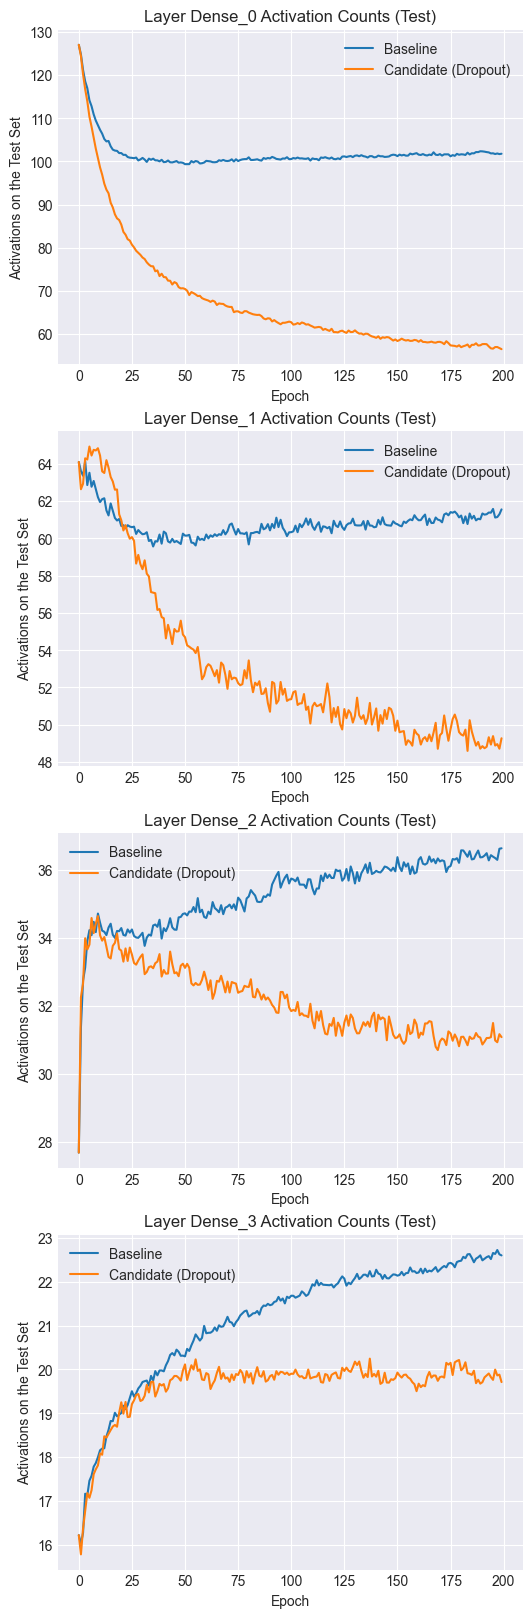

In [12]:
def get_activation_stats(model, phase, layer):
    baseline_activation_counts = []
    baseline_dead_neuron_counts = []
    dead_neuron_mask = None
    for i in range(num_epochs):
        baseline_outputs =  load_outputs_from_disk(model, phase, i, layer)
        baseline_datapoints = baseline_outputs.shape[0]

        active_baseline_outputs = baseline_outputs[baseline_outputs > 0]
        bcount = active_baseline_outputs.flatten().shape[0]/baseline_datapoints
        baseline_activation_counts.append(bcount)
    
    return baseline_activation_counts, baseline_dead_neuron_counts


fix, ax = plt.subplots(4, 1, figsize=[6,5*4])

for layer in range(4):

    baseline_test_activation_counts, baseline_test_dead_neuron_counts = get_activation_stats("Baseline", "test", f"Relu_{layer}")
    candidate_test_activation_counts, candidate_test_dead_neuron_counts = get_activation_stats("Candidate", "test", f"Dropout_{layer}") 

    ax[layer].plot(baseline_test_activation_counts)
    ax[layer].plot(candidate_test_activation_counts)
    ax[layer].set_title(f"Layer Dense_{layer} Activation Counts (Test)")
    ax[layer].set_xlabel("Epoch")
    ax[layer].set_ylabel("Activations on the Test Set")
    ax[layer].legend(["Baseline", "Candidate (Dropout)"])


plt.show()

Notice that both the baseline and candidate models have similar numbers of activated neurons at the start of training. However, as training progresses, the candidate model tends to have fewer activations per training example. Dropout thus encourages sparse representations, which, as we saw in the results, also tend to be more robust to changes in the inputs (i.e. regularization). 


In the baseline model, a neuron tends to co-adapt to other specific neurons, which leads to overfitting. By using dropout, a neuron cannot necessarily depend on other units and has to individually learn a more robust function. 

Next, let's look at the activation statistics.

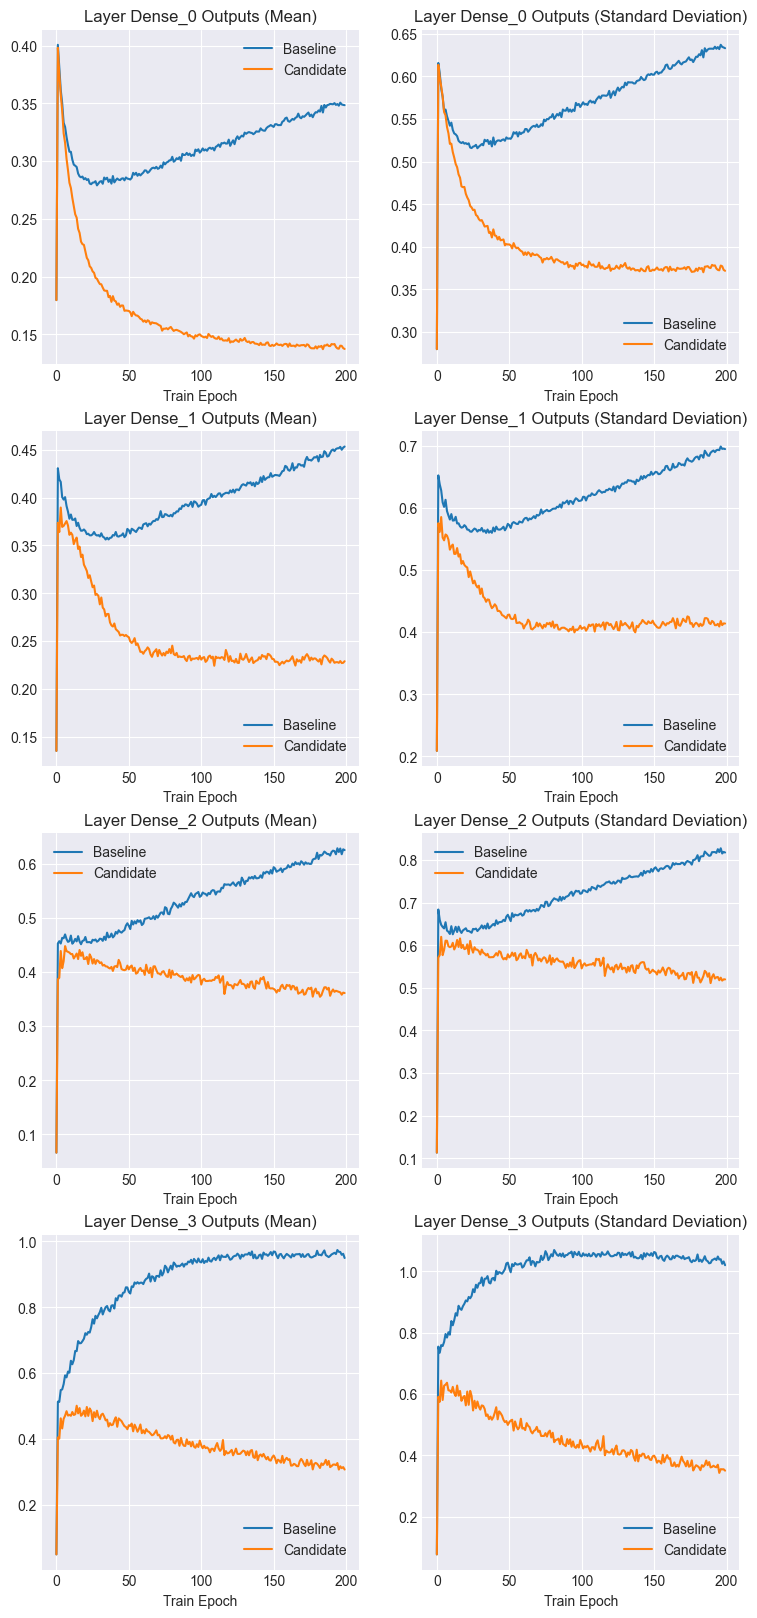

In [13]:
fig, axs = plt.subplots(4, 2, figsize=(9,5*4))

for l in range(4):

    baseline_output_means = []
    baseline_output_stds = []
    candidate_output_means = []
    candidate_output_stds = []

    for i in range(num_epochs):
        baseline_o1 = load_outputs_from_disk("Baseline", "train", i, f"Relu_{l}")
        baseline_m1 = baseline_o1.mean()
        baseline_output_means.append(baseline_m1)
        baseline_s1 = baseline_o1.std()
        baseline_output_stds.append(baseline_s1)

        candidate_o1 = load_outputs_from_disk("Candidate", "train", i, f"Dropout_{l}")
        candidate_m1 = candidate_o1.mean()
        candidate_output_means.append(candidate_m1)
        candidate_s1 = candidate_o1.std()
        candidate_output_stds.append(candidate_s1)

    axs[l,0].set_title(f"Layer Dense_{l} Outputs (Mean)")
    axs[l,0].set_xlabel("Train Epoch")
    axs[l,0].plot(baseline_output_means)
    axs[l,0].plot(candidate_output_means)

    axs[l,1].set_title(f"Layer Dense_{l} Outputs (Standard Deviation)")
    axs[l,1].set_xlabel("Train Epoch")
    axs[l,1].plot(baseline_output_stds)
    axs[l,1].plot(candidate_output_stds)

    axs[l,0].legend(["Baseline", "Candidate"])
    axs[l,1].legend(["Baseline", "Candidate"])

plt.show()

Notice that both the mean and standard deviation of the baseline activations increase as training progressses. However, the candidate activation statistics tend to stabilize and even decrease. 

Let's confirm this by comparing activation histograms.

In [14]:
baseline_all_outputs = []
candidate_all_outputs = []
num_epochs = 200
for l in range(4):
    outputs = load_outputs_from_disk("Baseline", "test", num_epochs-1, f"Relu_{l}").flatten()
    baseline_all_outputs.append(outputs)
    outputs = load_outputs_from_disk("Candidate", "test", num_epochs-1, f"Relu_{l}").flatten()
    candidate_all_outputs.append(outputs)


baseline_all_outputs = jnp.concat(baseline_all_outputs, axis=0)  
candidate_all_outputs = jnp.concat(candidate_all_outputs, axis=0)


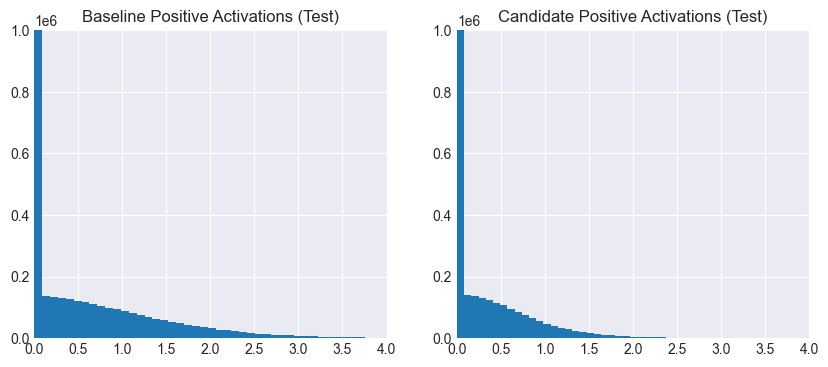

In [15]:
fig, axs = plt.subplots(1, 2, figsize=[10,4])

axs[0].hist(baseline_all_outputs, bins=100)
axs[0].set_xlim(0.00,4.0)
axs[0].set_ylim(0,1e6)
axs[0].set_title("Baseline Positive Activations (Test)")

axs[1].hist(candidate_all_outputs, bins=100)
axs[1].set_xlim(0.00,4.0)
axs[1].set_ylim(0,0.1e7)
axs[1].set_title("Candidate Positive Activations (Test)")

plt.show()

It's clear that the baseline activations are more spread out than the candidate ones, which are more sparse and smaller in magnitude. Thus, not only are fewer neurons activated per example, but the magnitudes of the activations themselves are diminished. This is due to the network having learned to avoid overly depending on specific neurons across training examples.

### Ensembling

Dropout can also be seen as a way of creating an ensemble of models with shared weights. Mathematically, a single neural network with dropout is an ensemble of $2^n$ models, where $n$ is the number of neurons. Each model in this ensemble is selected for a training step with a probability of $(1-p)^k$, where $k$ is the size of the model. 

In the light of this, we can explain the fewer and sparser activations as smaller sub-networks specializing in recognizing specific types of examples.

### References:

1. Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A simple way to prevent neural networks from overfitting. Journal of Machine Learning Research, 15(1).

2. Baldi, P., & Sadowski, P. (2013). Understanding dropout. Advances in Neural Information Processing Systems, 26.

3. Sutskever, I., Martens, J., Dahl, G., & Hinton, G. (2013). On the importance of initialization and momentum in deep learning. In Proceedings of the 30th International Conference on Machine Learning (ICML-13).

4. Nair, V., & Hinton, G. E. (2010). Rectified linear units improve restricted Boltzmann machines. In Proceedings of the 27th International Conference on Machine Learning (ICML-10).

